In [1]:
import horton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def get_hf_density(bond_length, reference, mixing_value):
    horton.log.set_level(0)

    mol = horton.IOData()
    bond_length = float(bond_length)
    mol.coordinates = np.array([[0.0, 0.0, -bond_length/2.], [0.0, 0.0, bond_length/2.]]) * horton.angstrom
    mol.numbers = np.array(reference)
    mol.pseudo_numbers = np.array([7., 7.]) * mixing_value + mol.numbers * (1-mixing_value)
    
    grid = horton.BeckeMolGrid(mol.coordinates, np.array([7, 7]), np.array([7.,7.]), 'insane', mode='keep', random_rotate=False)

    # build basis set
    basisset = 'def2-TZVP'#'6-31G(d)'
    obasis = horton.get_gobasis(mol.coordinates, np.array([7, 7]), basisset)
    obasis2 = horton.get_gobasis(mol.coordinates, np.array(reference), basisset)
    obasis = horton.GOBasis.concatenate(obasis, obasis2)
    
    #lf = horton.DenseLinalgFactory(obasis.nbasis)
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)
    #orb_alpha = lf.create_expansion()
    #orb_beta = lf.create_expansion()
    
    one = kin + na
    horton.guess_core_hamiltonian(olp,one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    
    terms = [horton.UTwoIndexTerm(kin, 'kin'), horton.UDirectTerm(er, 'hartree'), horton.UExchangeTerm(er, 'x_hf'), horton.UTwoIndexTerm(na, 'ne')]
    ham = horton.UEffHam(terms, external)
    occ_model = horton.AufbauOccModel(7, 7)
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    scf_solver = horton.ODASCFSolver(1e-5, maxiter=400)
    #scf_solver = horton.PlainSCFSolver(1e-6)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    #fock_alpha = np.zeros(olp.shape)
    #fock_beta = np.zeros(olp.shape)
    ham.reset(dm_alpha, dm_beta)
    energy = ham.compute_energy()
    #ham.compute_fock(fock_alpha, fock_beta)
    #orb_alpha.from_fock_and_dm(fock_alpha, dm_alpha, olp)
    #orb_beta.from_fock_and_dm(fock_beta, dm_beta, olp)

    # integration grid
    rho_alpha = obasis.compute_grid_density_dm(dm_alpha, grid.points)
    rho_beta = obasis.compute_grid_density_dm(dm_beta, grid.points)
    rho_full = rho_alpha + rho_beta
    
    ener, den, nuc = energy, rho_full, external['nn']
    return mol.coordinates, grid, {'bond': bond_length, 'mixing': mixing_value, 'energy': ener, 'density': den, 'Enn': nuc, 'reference': '-'.join(map(str, reference))}


In [3]:
coordcache = {}
gridcache = {}
results = []
for distance in (1.0, 1.2, 1.5, 1.7, 2.0):
    for refmol in ((8,8), (8, 6), (9, 5), (9, 9), (6,6)):
        try:
            for mixingval in np.linspace(0, 1, 11):
                molcoords, g, d = get_hf_density(distance, refmol, mixingval)
                results.append(d)
            coordcache[results[-1]['reference'] + str(int(distance*10))] = molcoords
            gridcache[results[-1]['reference'] + str(int(distance*10))] = g
        except:
            print (refmol, distance)
            pass
df = pd.DataFrame(results)
cache = df.sort_values('mixing')

In [90]:
def integrate():
    ret = []
    for name, group in cache.groupby('reference bond'.split()):
        rhotilde = np.trapz(group.density.values, group.mixing.values, axis=0)
        #grid = grids[grids.bond == group.bond.unique()[0]].iloc[0]
        grid = gridcache[name[0] + str(int(name[1]*10))]
        coordinates = coordcache[name[0] + str(int(name[1]*10))]
        dZ = [7-int(_) for _ in name[0][::2]]       

        for atom in range(2):
            
            contribution = -dZ[atom] * np.sum(rhotilde * grid.weights / np.linalg.norm(grid.points - coordinates[atom], axis=1))
            ret.append({'bond': group.bond.unique()[0], 'site': atom, 'energy': contribution, 'reference': name[0]})
    return pd.DataFrame(ret)
integrated = integrate()

In [91]:
integrated

,bond,energy,reference,site
0,1.0,-20.311849,6-6,0
1,1.0,-20.311849,6-6,1
2,1.2,-19.642694,6-6,0
3,1.2,-19.642694,6-6,1
4,1.5,-18.977553,6-6,0
5,1.5,-18.977553,6-6,1
6,1.7,-18.671336,6-6,0
7,1.7,-18.671336,6-6,1
8,2.0,-18.389253,6-6,0
9,2.0,-18.389253,6-6,1


In [61]:
df = pd.DataFrame(results)
cache = df.sort_values('mixing')

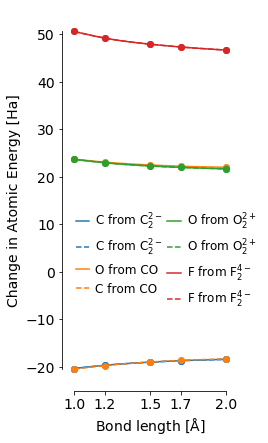

In [103]:
f = plt.figure(figsize=(3, 7))
plt.rc('font', size=14)

from scipy.interpolate import CubicSpline
lookup = {'6': 'C','9': 'F','8': 'O',}
names = {'6-6': 'C$_2^{2-}$', '8-8': 'O$_2^{2+}$', '9-9': 'F$_2^{4-}$', '8-6': 'CO'}

gidx = 0
handles = []
labels = []
for name, group in integrated.groupby('reference'.split()):
    s1 = group[group.site == 0]
    s2 = group[group.site == 1]
    try:
        ls = '-'
        spl = CubicSpline(s1.bond.values, s1.energy.values, bc_type='natural')
        xss = np.linspace(1, 2, 50)
        yss = spl(xss)
        plt.plot(s1.bond.values, s1.energy.values, 'o', label=names[name], color='C%d' % gidx)
        
        labels.append(lookup[name[0]] + ' from ' + names[name])
        h, =plt.plot(xss, yss, ls, label=names[name], color='C%d' % gidx)
        handles.append(h)
        if name[0] == name[-1]:
            ls = '--'
        else:
            ls = '--'
            
        spl = CubicSpline(s2.bond.values, s2.energy.values, bc_type='natural')
        xss = np.linspace(1, 2, 50)
        yss = spl(xss)
        plt.plot(s2.bond.values, s2.energy.values, 'o', label=names[name], color='C%d' % gidx)
        labels.append(lookup[name[-1]] + ' from ' + names[name])
        h, = plt.plot(xss, yss, ls, label=names[name], color='C%d' % gidx)
        
        handles.append(h)
        gidx += 1
    except:
        pass
plt.legend(handles, labels, bbox_to_anchor=(1.2, 0.5), ncol=2, fontsize = 12, frameon=False, handlelength=1.1, handletextpad=0.5, columnspacing=0.4)
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks((1.0, 1.2, 1.5, 1.7, 2.0))
ax.set_ylim(-25, 55)
ax.set_xlabel('Bond length [$\mathrm{\AA}$]')
ax.set_ylabel('Change in Atomic Energy [Ha]')
#ax.spines['bottom'].set_position(('outward', 5))
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['left'].set_position(('outward', 5))
ax.spines['left'].set_smart_bounds(True)
plt.savefig('otmr.pdf', bbox_inches='tight')

In [5]:
#df.to_pickle('otmr.pkl.gz')